In [6]:
from skimage.morphology import skeletonize, thin, binary_erosion
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import imageio
from scipy import misc
from skimage import color
from skimage import measure
import sys

#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as plx

np.set_printoptions(threshold=sys.maxsize, linewidth=1000)

In [8]:
## Tommy's Utility Functions
#Ok, let's write a formula that can convert from color to bw/binary image
def make_bw(img,thresh=130):
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    bw_img = bw_convert(gray_img,thresh)
    
    return bw_img


#Ok, let's convert the grayscale to a simple black-white: that may help us in observing the 
#"Fractal" structure (and other formal qualities)

def bw_convert(img,thresh):
    bw_pic = img.copy()
    bw_mask = bw_pic[:, :,] < thresh
    bw_pic[bw_mask] = 0
    bw_pic[~bw_mask] = 1
    return bw_pic


(335, 332, 3)
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True False  True  True  True  True  True  True  True  True  

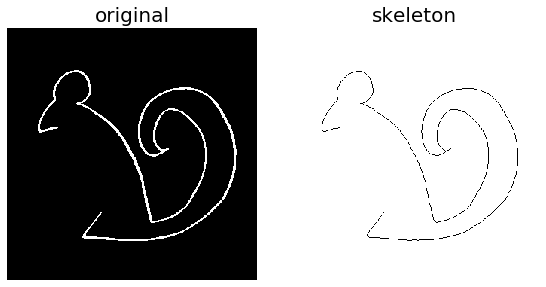

In [11]:
# Invert the squirrel image
squirrel = imageio.imread('images/squirrel.jpg') 
print(squirrel.shape)
squirrel_bw = invert(make_bw(squirrel))
skeleton = invert(thin(squirrel_bw))

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(squirrel_bw, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)
print(skeleton[150])

fig.tight_layout()
plt.show()

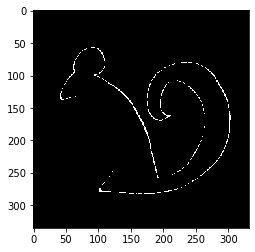

In [12]:
inverted_image = invert(make_bw(squirrel))
eroded_image = binary_erosion(inverted_image)


plt.imshow(eroded_image, cmap=plt.cm.gray)

Neither erosion or skeleton produces a nice continuous set of points; we'll have to go another route. We ultimately landed on using contours, and grabbing the "correct" 50% constituting one line.

This is a fairly manual process that mostly comprised of "guessing and checking", and in future iterations, we'd like to find a more elegant / automated solution to this.

(1, 3177, 2)


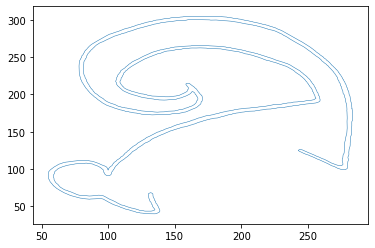

In [30]:
initial_image = imageio.imread("images/squirrel.jpg")
gray_scale_image = color.colorconv.rgb2grey(initial_image)
contours = measure.find_contours(gray_scale_image, 0.8)
# Now cast it to an NP array so it's more workable.
contours = np.array(contours)
print(contours.shape)

def rotate_points(coordinate_pair):
    rotation_matrix = np.array([
        [0, 1],
        [-1, 0]
    ])
    result = np.matmul(rotation_matrix, coordinate_pair)
    return result

def translate_y(coordinate_pair):
    # TODO: these numbers are super hard-coded --- is there a way to make
    # this more programmatic?
    result = [coordinate_pair[0], coordinate_pair[1] + 300]
    return result

contour = contours[0]
xs = contour[:, 0]
ys = contour[:, 1]
plt.plot(xs, ys,  linewidth=0.5)

# Do a reverse 90-degree matrix transformation on the points to rotate the image
contours = np.array([[rotate_points(cp) for cp in contours[0]]])
# And now move the points upwards by adding 300 to each point 
contours = np.array([[translate_y(cp) for cp in contours[0]]])

# TODO: perform a translate on the numbers so that the image moves closer to the origin.


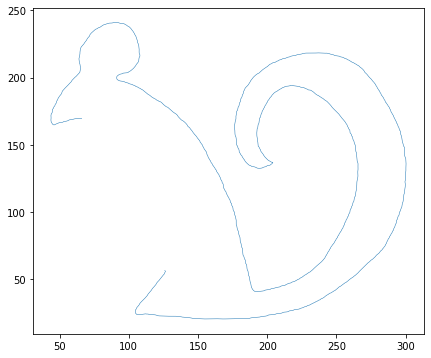

In [14]:
# Find the approximate 50% of the image to generate just one line; since the vector starts and ends at the same point
# This is a deeply manual process, and if we had the extra time, perhaps we could find a way to automate this.
row_start = 1465
row_end = 3025

# Now, we can plot the image
plt.figure(figsize=(7, 6))

contour = contours[0]
xs = contour[row_start:row_end, 0]
ys = contour[row_start:row_end, 1]
plt.plot(xs, ys,  linewidth=0.5)


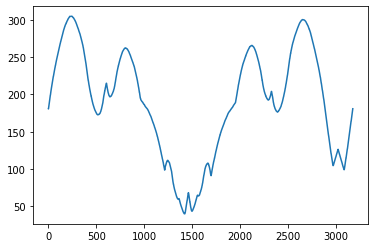

In [15]:
# To confirm that this is a continuous line that the vector gave us
plt.plot(contours[0, :, 0])
plt.show()


Text(0.5, 1.0, 'Squirrel, separated into line segments for interpolation')

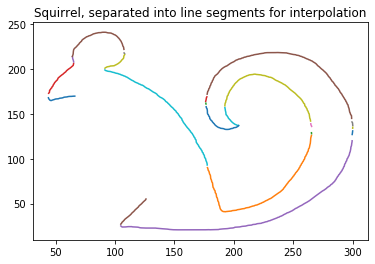

In [62]:
# Process so far: Use vectorization, grab roughly 50% of the line, since there's a start and end point
# Now that we have the continuous line traced, we'll run it through an algorithm to sectionize the line

line_contour = contours[0][row_start:row_end]

def extract_line_segments(line):
    # Stick initial point into a segment array
    all_segments = []
    segment_start = 0
    prev_direction = (line[0][0] - line[1][0]) < 0

    for index, coordinate in enumerate(line):
        if index == 0:
            # To handle the first case
            previous_x = coordinate[0]
            continue
        x, y = coordinate
        direction = (x - previous_x) > 0 
        # A positive direction is indicated by True, negative by False
        if direction != prev_direction:
            # If the direction of the X has changed, stick the index of the
            # last coordinate pair in the array, add that segment into the all_segments array
            # and start a new segment pair
            last_index = index - 1
            all_segments.append(line[segment_start:last_index])
            # start new segment
            segment_start = index
        # Now, set the last direction and last x as the previous one
        previous_x = x
        prev_direction = direction
    return np.array(all_segments)
    
line_segments = extract_line_segments(line_contour)

for line_segment in line_segments:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)

plt.title("Squirrel, separated into line segments for interpolation")

In [22]:
np.array((1, 2))

array([1, 2])